<a href="https://colab.research.google.com/github/Danysan1/ai-unibo-nlp-project/blob/main/a2/execution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2 execution

In [78]:
%pip install pandas numpy matplotlib transformers

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


## Data loading

### Dataset download

In [79]:
import os
import urllib.request
from tqdm import tqdm

class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)
        
def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def download_data(data_path, url_path, suffix):    
    if not os.path.exists(data_path):
        os.makedirs(data_path)
        
    data_path = os.path.join(data_path, f'{suffix}.json')
    if not os.path.exists(data_path):
        print(f"Downloading CoQA {suffix} data split... (it may take a while)")
        download_url(url=url_path, output_path=data_path)
        print("Download completed!")

In [80]:
data_folder = 'Dataset'

In [81]:
# Train data
train_url = "https://nlp.stanford.edu/data/coqa/coqa-train-v1.0.json"
download_data(data_path=data_folder, url_path=train_url, suffix='train')

# Test data
test_url = "https://nlp.stanford.edu/data/coqa/coqa-dev-v1.0.json"
download_data(data_path=data_folder, url_path=test_url, suffix='test')

### Dataset loading

In [82]:
import numpy as np
import pandas as pd
import json
from os import path
from matplotlib import pyplot as plt

In [83]:
def loadDataset(filename):
    with open(path.join(data_folder, filename)) as file_obj:
        df = json.load(file_obj)["data"]
    print(f'{len(df)} stories / {len(df[0]["questions"])} questions in the first row')

    storyDType = pd.CategoricalDtype(pd.unique([story["story"] for story in df]))
    print(f"{storyDType.categories.size} distinct stories")

    sourceDType = pd.CategoricalDtype(pd.unique([story["source"] for story in df]))
    print(f"{sourceDType.categories.size} distinct sources: {sourceDType.categories}")

    df = np.array([
        [
            sourceDType.categories.get_loc(story["source"]), # Sources factorization
            storyDType.categories.get_loc(story["story"]), # Sources factorization
            story["questions"][question_index]["input_text"],
            story["answers"][question_index]["input_text"],
            story["answers"][question_index]["span_text"],
        ]
        for story in df
        for question_index in range(len(story["questions"]))
        if story["answers"][question_index]["input_text"] != 'unknown'
    ])
    print(f'{df.shape} question-answer pairs x columns')
    print(f'First row: {df[0]}')
    
    # https://marcobonzanini.com/2021/09/15/tips-for-saving-memory-with-pandas/
    # https://pandas.pydata.org/docs/user_guide/categorical.html
    df = pd.DataFrame({
        "source": pd.Series(pd.Categorical.from_codes(df[:,0].astype(np.int16), dtype=sourceDType)),
        "p": pd.Series(pd.Categorical.from_codes(df[:,1].astype(np.int16), dtype=storyDType)),
        "q": df[:,2],
        "a": df[:,3],
        "span": df[:,4],
    })

    return df

In [84]:
train_df = loadDataset("train.json")
train_df.count()

7199 stories / 20 questions in the first row
6605 distinct stories
5 distinct sources: Index(['wikipedia', 'cnn', 'gutenberg', 'race', 'mctest'], dtype='object')
(107276, 5) question-answer pairs x columns
First row: ['0' '0' 'When was the Vat formally opened?'
 'It was formally established in 1475' 'Formally established in 1475']


source    107276
p         107276
q         107276
a         107276
span      107276
dtype: int64

In [85]:
pd.unique(train_df["p"]).size

6605

In [86]:
pd.unique(train_df["span"]).size

99470

In [87]:
pd.unique(train_df["source"]).size

5

In [88]:
train_df.head()

,source,p,q,a,span
0,wikipedia,"The Vatican Apostolic Library (), more commonl...",When was the Vat formally opened?,It was formally established in 1475,Formally established in 1475
1,wikipedia,"The Vatican Apostolic Library (), more commonl...",what is the library for?,research,he Vatican Library is a research library
2,wikipedia,"The Vatican Apostolic Library (), more commonl...",for what subjects?,"history, and law",Vatican Library is a research library for hist...
3,wikipedia,"The Vatican Apostolic Library (), more commonl...",and?,"philosophy, science and theology",Vatican Library is a research library for hist...
4,wikipedia,"The Vatican Apostolic Library (), more commonl...",what was started in 2014?,a project,"March 2014, the Vatican Library began an initi..."


In [89]:
train_df.memory_usage(deep=True)

Index          128
source      107764
p         14241201
q          9110271
a          7714559
span      12090637
dtype: int64

In [90]:
#test_df = loadDataset("test.json")
#test_df.count()

## Data Pre-Processing

### Check unanswerable questions in the Train Dataset

In [91]:
idx = (train_df.a == 'unknown')
unanswerable = train_df[idx]
unanswerable.q.count()

0

All unanswerable questions in the Train Dataset have been already removed.

## Exploratory Data Analysis

In [92]:
train_df["p"][42]

'CHAPTER VII. THE DAUGHTER OF WITHERSTEEN \n\n"Lassiter, will you be my rider?" Jane had asked him. \n\n"I reckon so," he had replied. \n\nFew as the words were, Jane knew how infinitely much they implied. She wanted him to take charge of her cattle and horse and ranges, and save them if that were possible. Yet, though she could not have spoken aloud all she meant, she was perfectly honest with herself. Whatever the price to be paid, she must keep Lassiter close to her; she must shield from him the man who had led Milly Erne to Cottonwoods. In her fear she so controlled her mind that she did not whisper this Mormon\'s name to her own soul, she did not even think it. Besides, beyond this thing she regarded as a sacred obligation thrust upon her, was the need of a helper, of a friend, of a champion in this critical time. If she could rule this gun-man, as Venters had called him, if she could even keep him from shedding blood, what strategy to play his flame and his presence against the g

In [93]:
train_df["q"][42]

'Was Lassiter impressed with the horse?'

In [94]:
train_df["a"][42]

'Yes'

In [95]:
train_df["span"][42]

'When Jerd led out this slender, beautifully built horse Lassiter suddenly became all eyes.'

In [96]:
train_df["source"][42]

'gutenberg'

### Distribution statistics

<AxesSubplot:>

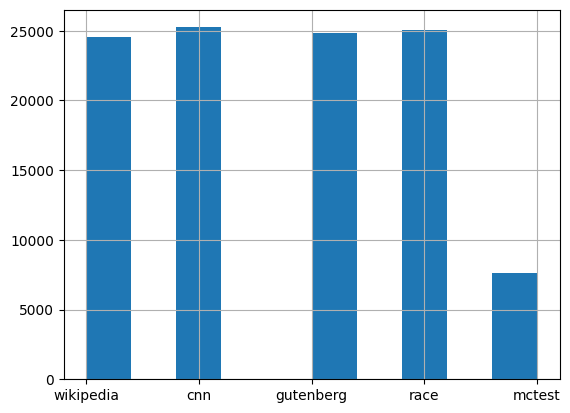

In [97]:
train_df["source"].hist()

/tmp/ipykernel_1790/3127963000.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  story_counts[:25].plot(kind="bar", figsize=(15,5))


<AxesSubplot:>

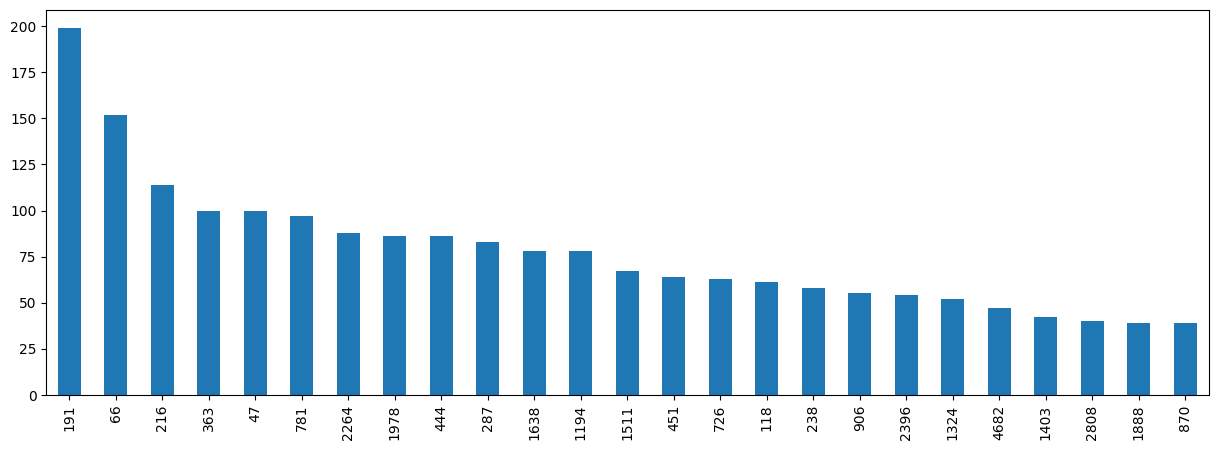

In [98]:
story_counts = train_df["p"].cat.codes.value_counts(sort=True)
story_counts[:25].plot(kind="bar", figsize=(15,5))

/tmp/ipykernel_1790/3421603498.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  story_counts[-25:-1].plot(kind="bar", figsize=(15,5))


<AxesSubplot:>

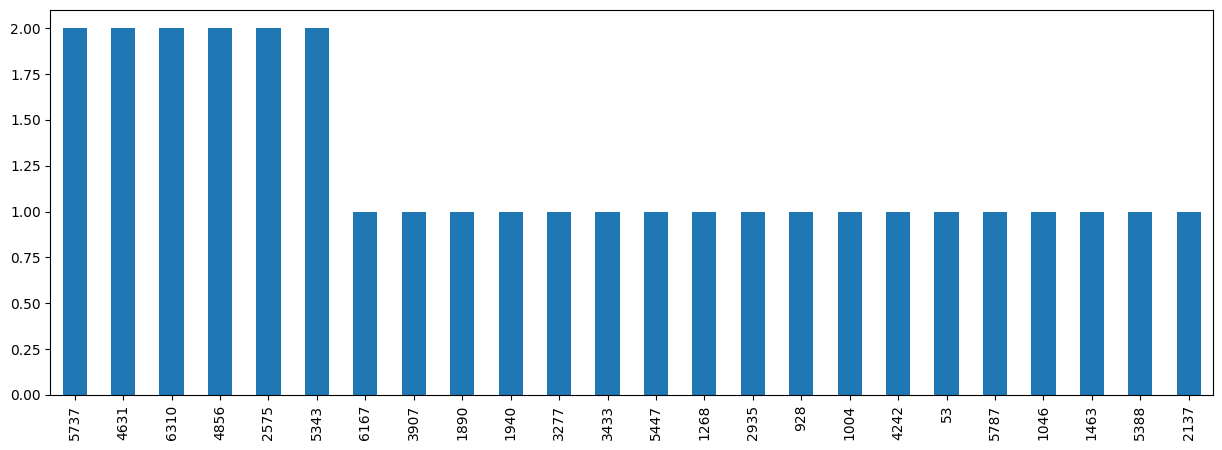

In [99]:
story_counts[-25:-1].plot(kind="bar", figsize=(15,5))

<AxesSubplot:>

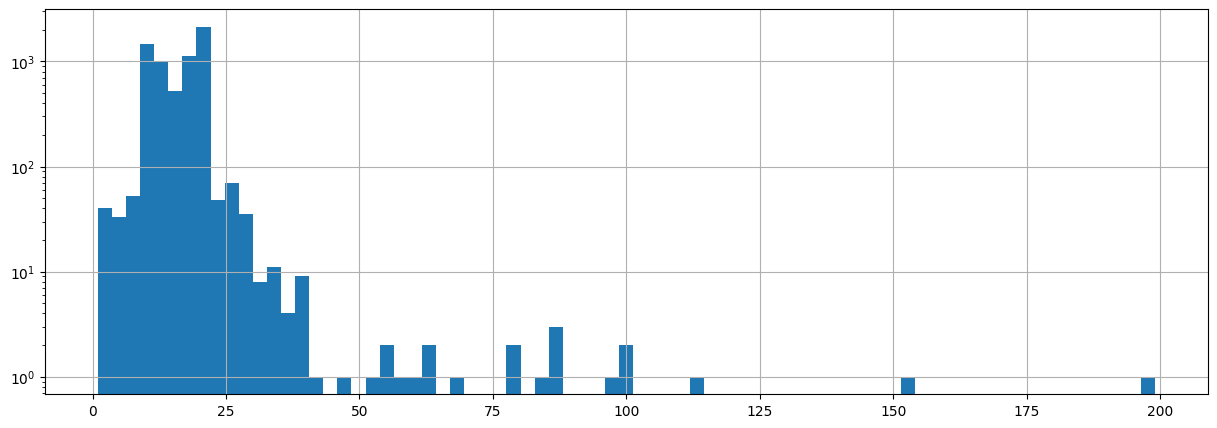

In [105]:
story_counts.hist(log=True,bins=75,figsize=(15,5))

## Train-Validation-Test split

In [101]:
# TODO

## Model definition

### Utilities

In [21]:
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from typing import List, Dict, Callable
import random

2022-12-25 16:18:07.797042: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-25 16:18:08.201441: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/anaconda3/pkgs/cudatoolkit-11.2.2-hbe64b41_10/lib/libcudart.so.11.0
2022-12-25 16:18:08.201479: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-25 16:18:09.343313: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'

In [22]:
def predict_data(model: keras.Model,
                x: np.ndarray,
                prediction_info: Dict):
    """
    Inference routine of a given input set of examples

    :param model: Keras built and possibly trained model
    :param x: input set of examples in np.ndarray format
    :param prediction_info: dictionary storing model predict() argument information

    :return
        predictions: predicted labels in np.ndarray format
    """
    print(f'Starting prediction: \n{prediction_info}')
    print(f'Predicting on {x.shape[0]} samples')
    predictions = model.predict(x, **prediction_info)
    return predictions

In [23]:
def compute_f1(model: keras.Model, 
             x: np.ndarray, 
             y: np.ndarray):
    """
    Compute F1_score on the given data with corresponding labels

    :param model: Keras built and possibly trained model
    :param x: data in np.ndarray format
    :param y: ground-truth labels in np.ndarray format

    :return
        score: f1_macro_score
    """
    #predictions on the x set
    prediction_info = {
        'batch_size': 64,
        'verbose': 1
    }
    y_pred = predict_data(model=model, x=x, prediction_info=prediction_info)

    #compute argmax to take the best class for each sample
    y_pred = np.argmax(y_pred, axis=1)
    #compute the f1_macro
    score = f1_score(y, y_pred, average ='macro')
    return score

In [24]:
def set_reproducibility(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [25]:
import tensorflow as tf
import tensorflow_addons as tfa
from tqdm import tqdm
from transformers import TFAutoModel, AutoTokenizer

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

/opt/anaconda3/envs/nlp/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,
2022-12-25 16:18:26.657379: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-25 16:18:26.657678: W tensor

### Question generation $f_\theta(P, Q)$ with text passage $P$ and question $Q$

### Seq2Seq LSTM

In [ ]:
class MyTrainer(object):
    """
    Simple wrapper class

    train_op -> uses tf.GradientTape to compute the loss
    batch_fit -> receives a batch and performs forward-backward passes (gradient included)
    """

    def __init__(self, encoder, decoder, max_length):
        self.encoder = encoder
        self.decoder = decoder
        self.max_length = max_length
        self.ce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-03)

    @tf.function
    def compute_loss(self, logits, target):
        loss = self.ce(y_true=target, y_pred=logits)
        mask = tf.logical_not(tf.math.equal(target, 0))
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_mean(loss)

    @tf.function
    def train_op(self, inputs):
        with tf.GradientTape() as tape:
            encoder_output, encoder_h, encoder_s = self.encoder({'input_ids': inputs['encoder_input_ids'],
                                                                 'hidden_state': inputs['encoder_state']})

            decoder_input = inputs['decoder_target'][:, :-1]  # ignore <end>
            real_target = inputs['decoder_target'][:, 1:]  # ignore <start>

            decoder.attention.setup_memory(encoder_output)

            decoder_initial_state = self.decoder.build_initial_state(decoder.batch_size, [encoder_h, encoder_s])
            predicted = self.decoder({'input_ids': decoder_input,
                                      'initial_state': decoder_initial_state}).rnn_output

            loss = self.compute_loss(logits=predicted, target=real_target)

        grads = tape.gradient(loss, self.encoder.trainable_variables + self.decoder.trainable_variables)
        return loss, grads

    @tf.function
    def batch_fit(self, inputs):
        loss, grads = self.train_op(inputs=inputs)
        self.optimizer.apply_gradients(zip(grads, self.encoder.trainable_variables + self.decoder.trainable_variables))
        return loss

    @tf.function
    def generate(self, input_ids):
        batch_size = input_ids.shape[0]
        encoder_initial_state = [tf.zeros((batch_size, self.encoder.encoder_units)),
                                 tf.zeros((batch_size, self.encoder.encoder_units))]
        encoder_output, encoder_h, encoder_s = self.encoder({
            'input_ids': input_ids,
            'hidden_state': encoder_initial_state
        })

        start_tokens = tf.fill([batch_size], tokenizer.word_index['<start>'])
        end_token = tokenizer.word_index['<end>']

        greedy_sampler = tfa.seq2seq.GreedyEmbeddingSampler()
        decoder_instance = tfa.seq2seq.BasicDecoder(cell=self.decoder.wrapped_decoder_cell,
                                                    sampler=greedy_sampler,
                                                    output_layer=self.decoder.generation_dense,
                                                    maximum_iterations=self.max_length)
        self.decoder.attention.setup_memory(encoder_output)

        decoder_initial_state = self.decoder.build_initial_state(batch_size, [encoder_h, encoder_s])
        decoder_embedding_matrix = self.decoder.embedding.variables[0]
        outputs, _, _ = decoder_instance(decoder_embedding_matrix,
                                         start_tokens=start_tokens,
                                         end_token=end_token,
                                         initial_state=decoder_initial_state)
        return outputs

    def translate(self, generated):
        return tokenizer.sequences_to_texts(generated.sample_id.numpy())


class Encoder(tf.keras.Model):

    def __init__(self, vocab_size, embedding_dim, encoder_units):
        super(Encoder, self).__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.encoder_units = encoder_units

        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size,
                                                   output_dim=embedding_dim)
        self.encoder_lstm = tf.keras.layers.LSTM(self.encoder_units,
                                                 return_sequences=True,
                                                 return_state=True)

    def call(self, inputs, training=False, **kwargs):
        input_ids = inputs['input_ids']
        input_emb = self.embedding(input_ids)
        encoder_output, lstm_hidden, lstm_states = self.encoder_lstm(input_emb, initial_state=inputs['hidden_state'])
        return encoder_output, lstm_hidden, lstm_states

    def initialize(self, batch_size):
        return [tf.zeros((batch_size, self.encoder_units)), tf.zeros((batch_size, self.encoder_units))]


class Decoder(tf.keras.Model):

    def __init__(self, vocab_size, max_sequence_length, embedding_dim, decoder_units, batch_size):
        super(Decoder, self).__init__()

        self.max_sequence_length = max_sequence_length
        self.batch_size = batch_size

        self.decoder_units = decoder_units
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size,
                                                   output_dim=embedding_dim)
        self.decoder_lstm_cell = tf.keras.layers.LSTMCell(self.decoder_units)

        self.attention = tfa.seq2seq.BahdanauAttention(units=self.decoder_units,
                                                       memory=None,
                                                       memory_sequence_length=self.batch_size * [max_sequence_length])

        self.wrapped_decoder_cell = tfa.seq2seq.AttentionWrapper(self.decoder_lstm_cell,
                                                                 self.attention,
                                                                 attention_layer_size=self.decoder_units)

        self.generation_dense = tf.keras.layers.Dense(vocab_size)
        self.sampler = tfa.seq2seq.sampler.TrainingSampler()
        self.decoder = tfa.seq2seq.BasicDecoder(self.wrapped_decoder_cell,
                                                sampler=self.sampler,
                                                output_layer=self.generation_dense)

    def build_initial_state(self, batch_size, encoder_state):
        initial_state = self.wrapped_decoder_cell.get_initial_state(batch_size=batch_size, dtype=tf.float32)
        initial_state = initial_state.clone(cell_state=encoder_state)
        return initial_state

    def call(self, inputs, training=False, **kwargs):
        input_ids = inputs['input_ids']
        input_emb = self.embedding(input_ids)
        decoder_output, _, _ = self.decoder(input_emb,
                                            initial_state=inputs['initial_state'],
                                            sequence_length=self.batch_size * [self.max_sequence_length - 1])
        return decoder_output

In [ ]:
# Sample
input_sample = [
    "hello there how is it going",
    "this assignment is hellish"
]
output_sample = [
    "<start> it is going well <end>",
    "<start> I agree <end>"
]

batch_size = len(input_sample)

tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<UNK>')
tokenizer.fit_on_texts(input_sample + output_sample)

vocab_size = len(tokenizer.word_index) + 1

encoded_input_sample = tokenizer.texts_to_sequences(input_sample)
max_input_length = max([len(item) for item in encoded_input_sample])

encoded_output_sample = tokenizer.texts_to_sequences(output_sample)
max_output_length = max([len(item) for item in encoded_output_sample])

max_sequence_length = max(max_input_length, max_output_length)

encoded_input_sample = tf.keras.preprocessing.sequence.pad_sequences(encoded_input_sample,
                                                                        padding='post',
                                                                        maxlen=max_sequence_length)
encoded_output_sample = tf.keras.preprocessing.sequence.pad_sequences(encoded_output_sample,
                                                                        padding='post',
                                                                        maxlen=max_sequence_length)

# Test encoder
encoder = Encoder(vocab_size=vocab_size,
                    embedding_dim=50,
                    encoder_units=16)

sample_hidden = encoder.initialize(batch_size=batch_size)
encoder_sample_batch = {
    'input_ids': tf.convert_to_tensor(encoded_input_sample, dtype=tf.int32),
    'hidden_state': sample_hidden
}

sample_output, sample_h, sample_c = encoder(inputs=encoder_sample_batch)
print(f'{sample_output.shape} -- {sample_h.shape} -- {sample_c.shape}')

# Test decoder
decoder = Decoder(vocab_size=vocab_size,
                    embedding_dim=50,
                    decoder_units=16,
                    batch_size=batch_size,
                    max_sequence_length=max_sequence_length)
decoder.attention.setup_memory(sample_output)
initial_state = decoder.build_initial_state(batch_size, [sample_h, sample_c])

decoder_sample_batch = {
    'input_ids': tf.convert_to_tensor(encoded_output_sample, tf.int32),
    'initial_state': initial_state
}
sample_decoder_outputs = decoder(decoder_sample_batch).rnn_output
print(f'{sample_decoder_outputs.shape}')

2022-12-14 00:08:14.456810: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(2, 6, 16) -- (2, 16) -- (2, 16)
(2, 5, 16)


In [ ]:
# Training
trainer = MyTrainer(encoder=encoder,
                    decoder=decoder,
                    max_length=max_sequence_length)

In [ ]:
epochs = 100
for epoch in tqdm(range(epochs)):
    encoder_hidden_state = encoder.initialize(batch_size=batch_size)
    batch = {
        'encoder_input_ids': encoded_input_sample,
        'encoder_state': encoder_hidden_state,
        'decoder_target': encoded_output_sample
    }
    loss = trainer.batch_fit(batch)
    print(f'Loss - {loss}')

    generated = trainer.generate(input_ids=encoded_input_sample)
    translated = trainer.translate(generated)
    print(f'Translated - {translated}')

  0%|          | 0/100 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
#TODO

### Seq2Seq Bert-Tiny

In [26]:
class MyTrainer(object):
    """
    Simple wrapper class

    train_op -> uses tf.GradientTape to compute the loss
    batch_fit -> receives a batch and performs forward-backward passes (gradient included)
    """

    def __init__(self, encoder, decoder, max_length):
        self.encoder = encoder
        self.decoder = decoder
        self.max_length = max_length
        self.ce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-03)

    @tf.function
    def compute_loss(self, logits, target):
        loss = self.ce(y_true=target, y_pred=logits)
        mask = tf.logical_not(tf.math.equal(target, 0))
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_mean(loss)

    @tf.function
    def train_op(self, inputs):
        with tf.GradientTape() as tape:
            encoder_output, encoder_h, encoder_s = self.encoder({'input_ids': inputs['encoder_input_ids'],
                                                                 'attention_mask': inputs['encoder_attention_mask']})

            decoder_input = inputs['decoder_target'][:, :-1]  # ignore <end>
            real_target = inputs['decoder_target'][:, 1:]  # ignore <start>

            decoder.attention.setup_memory(encoder_output)

            decoder_initial_state = self.decoder.build_initial_state(decoder.batch_size, [encoder_h, encoder_s])
            predicted = self.decoder({'input_ids': decoder_input,
                                      'initial_state': decoder_initial_state}).rnn_output

            loss = self.compute_loss(logits=predicted, target=real_target)

        grads = tape.gradient(loss, self.encoder.trainable_variables + self.decoder.trainable_variables)
        return loss, grads

    @tf.function
    def batch_fit(self, inputs):
        loss, grads = self.train_op(inputs=inputs)
        self.optimizer.apply_gradients(zip(grads, self.encoder.trainable_variables + self.decoder.trainable_variables))
        return loss

    # @tf.function
    def generate(self, input_ids, attention_mask=None):
        batch_size = input_ids.shape[0]
        encoder_output, encoder_h, encoder_s = self.encoder({
            'input_ids': input_ids,
            'attention_mask': attention_mask
        })

        start_tokens = tf.fill([batch_size], output_tokenizer.word_index['<start>'])
        end_token = output_tokenizer.word_index['<end>']

        greedy_sampler = tfa.seq2seq.GreedyEmbeddingSampler()
        decoder_instance = tfa.seq2seq.BasicDecoder(cell=self.decoder.wrapped_decoder_cell,
                                                    sampler=greedy_sampler,
                                                    output_layer=self.decoder.generation_dense,
                                                    maximum_iterations=self.max_length)
        self.decoder.attention.setup_memory(encoder_output)

        decoder_initial_state = self.decoder.build_initial_state(batch_size, [encoder_h, encoder_s])
        decoder_embedding_matrix = self.decoder.embedding.variables[0]
        outputs, _, _ = decoder_instance(decoder_embedding_matrix,
                                         start_tokens=start_tokens,
                                         end_token=end_token,
                                         initial_state=decoder_initial_state)
        return outputs

    def translate(self, generated):
        return output_tokenizer.sequences_to_texts(generated.sample_id.numpy())


class Encoder(tf.keras.Model):

    def __init__(self, model_name, decoder_units):
        super(Encoder, self).__init__()
        self.model = TFAutoModel.from_pretrained(model_name, from_pt=True)
        self.reducer = tf.keras.layers.Dense(decoder_units)

    def call(self, inputs, training=False, **kwargs):
        model_output = self.model(inputs)
        all_outputs = model_output[0]
        pooled_output = model_output[1]
        pooled_output = self.reducer(pooled_output)
        return all_outputs, pooled_output, pooled_output


class Decoder(tf.keras.Model):

    def __init__(self, vocab_size, max_sequence_length, embedding_dim, decoder_units, batch_size):
        super(Decoder, self).__init__()

        self.max_sequence_length = max_sequence_length
        self.batch_size = batch_size

        self.decoder_units = decoder_units
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size,
                                                   output_dim=embedding_dim)
        self.decoder_lstm_cell = tf.keras.layers.LSTMCell(self.decoder_units)

        self.attention = tfa.seq2seq.BahdanauAttention(units=self.decoder_units,
                                                       memory=None,
                                                       memory_sequence_length=self.batch_size * [max_sequence_length])

        self.wrapped_decoder_cell = tfa.seq2seq.AttentionWrapper(self.decoder_lstm_cell,
                                                                 self.attention,
                                                                 attention_layer_size=self.decoder_units)

        self.generation_dense = tf.keras.layers.Dense(vocab_size)
        self.sampler = tfa.seq2seq.sampler.TrainingSampler()
        self.decoder = tfa.seq2seq.BasicDecoder(self.wrapped_decoder_cell,
                                                sampler=self.sampler,
                                                output_layer=self.generation_dense)

    def build_initial_state(self, batch_size, encoder_state):
        initial_state = self.wrapped_decoder_cell.get_initial_state(batch_size=batch_size, dtype=tf.float32)
        initial_state = initial_state.clone(cell_state=encoder_state)
        return initial_state

    def call(self, inputs, training=False, **kwargs):
        input_ids = inputs['input_ids']
        input_emb = self.embedding(input_ids)
        decoder_output, _, _ = self.decoder(input_emb,
                                            initial_state=inputs['initial_state'],
                                            sequence_length=self.batch_size * [self.max_sequence_length - 1])
        return decoder_output


In [27]:
from transformers import BertForQuestionAnswering, AutoTokenizer, AutoConfig

model_name = 'prajjwal1/bert-tiny'

#config = AutoConfig.from_pretrained(model_name)
#model = BertForQuestionAnswering.from_pretrained(model_name, config=config)
input_tokenizer = AutoTokenizer.from_pretrained(model_name)

The next block of code is an example of encoding of a question-context pair: in this case, the question is the first part of the encoding, and the context is the second part. There are two special tokens: [CLS] token at the start of the encoding, [SEP] token between the question and the context, and at the end of the encoding.

In this case the context is the *span*, to provide a better example that explains the encoding.

In [29]:
line = 42

encoded_question = input_tokenizer(train_df['q'][line], return_tensors='tf', padding=True)
print(train_df['q'][line])

encoded_span = input_tokenizer(train_df['span'][line], return_tensors='tf', padding=True)
print(train_df['span'][line])

encoded_qs = input_tokenizer(train_df['q'][line], train_df['span'][line], return_tensors='tf', padding=True)

print('= '*40)
for idx, tok in zip(encoded_qs.input_ids.numpy()[0], input_tokenizer.convert_ids_to_tokens(encoded_qs.input_ids[0])):
    print("{}\t{}".format(idx, tok))

Was Lassiter impressed with the horse?
When Jerd led out this slender, beautifully built horse Lassiter suddenly became all eyes.
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
101	[CLS]
2001	was
27333	lass
21646	##iter
7622	impressed
2007	with
1996	the
3586	horse
1029	?
102	[SEP]
2043	when
15333	je
4103	##rd
2419	led
2041	out
2023	this
10944	slender
1010	,
17950	beautifully
2328	built
3586	horse
27333	lass
21646	##iter
3402	suddenly
2150	became
2035	all
2159	eyes
1012	.
102	[SEP]


Lets encode a part of the dataset in sentences of: [CLS] question [SEP] passage [SEP]. Otherwise, the training would be very slow.

In [30]:
max_length = 512  # The maximum length of a feature (question and context)
doc_stride = (
    128  # The authorized overlap between two part of the context when splitting
)
sentences = 20
sample = 10

In [32]:
# Input
qs = train_df['q'][range(sentences)] # questions
cs = train_df['p'][range(sentences)] # contexts

batch_size = len(qs)

encoded_inputs = input_tokenizer(
    qs.values.tolist(),
    cs.values.tolist(),
    #train_df['q'].values.tolist(),
    #train_df['p'].values.tolist(),
    truncation="only_second",
    max_length=max_length,
    stride=doc_stride,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    padding="max_length",
    return_tensors='tf'
)

input_ids, attention_mask = encoded_inputs.input_ids, encoded_inputs.attention_mask
max_input_length = input_ids.shape[-1]

In [38]:
print("max_input_length:", max_input_length)
print("encoded_inputs shape =", encoded_inputs['input_ids'].shape)

max_input_length: 512
encoded_inputs shape = (20, 512)


The 'token_type_ids' encodes wether the encoded id is part of the question (=0) or the context (=1). The Attention Mask indicates if the input is needed (=1) or it's padding (=0).

Prepare also the expected outputs, for the training (this code follows the example given by the tutors, but I'm not convinced that this is the proper formatting for a QA Bert model).

In [39]:
# Output
outputs = "<start> " + train_df['a'][range(sentences)] + " <end>"

output_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token='<UNK>')
output_tokenizer.fit_on_texts(outputs)

output_vocab_size = len(output_tokenizer.word_index) + 1

encoded_output = output_tokenizer.texts_to_sequences(outputs)
print(encoded_output[sample])
max_output_length = max([len(item) for item in encoded_output])

[2, 30, 5, 31, 10, 5, 32, 33, 3]


In [42]:
max_sequence_length = max(max_input_length, max_output_length)

print("max_output_length: {}".format(max_output_length))
print("max_sequence_length: {}".format(max_sequence_length))

max_output_length: 11
max_sequence_length: 512


In [41]:
encoded_output = tf.keras.preprocessing.sequence.pad_sequences(encoded_output,
                                                                        padding='post',
                                                                        maxlen=max_sequence_length)
print(encoded_output[sample])

[ 2 30  5 31 10  5 32 33  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

In [43]:
# Test encoder
encoder = Encoder(model_name=model_name,
                    decoder_units=16)
encoder_output, encoder_h, encoder_s = encoder({'input_ids': input_ids,
                                                'attention_mask': attention_mask})
print(f'{encoder_output.shape} - {encoder_h.shape} - {encoder_s.shape}')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

(20, 512, 128) - (20, 16) - (20, 16)


In [44]:
# Test decoder
decoder = Decoder(vocab_size=output_vocab_size,
                    embedding_dim=50,
                    decoder_units=16,
                    batch_size=batch_size,
                    max_sequence_length=max_sequence_length)
decoder.attention.setup_memory(encoder_output)
initial_state = decoder.build_initial_state(batch_size, [encoder_h, encoder_s])

decoder_batch = {
    'input_ids': tf.convert_to_tensor(encoded_output, tf.int32),
    'initial_state': initial_state
}
decoder_outputs = decoder(decoder_batch).rnn_output
print(f'{decoder_outputs.shape}')

(20, 511, 63)


In [45]:
# Training
trainer = MyTrainer(encoder=encoder,
                    decoder=decoder,
                    max_length=max_sequence_length)

In [46]:
epochs = 3
for epoch in tqdm(range(epochs)):
    batch = {
        'encoder_input_ids': input_ids,
        'encoder_attention_mask': attention_mask,
        'decoder_target': encoded_output
    }
    loss = trainer.batch_fit(batch)
    print(f'Loss - {loss}')

    generated = trainer.generate(input_ids=input_ids,
                                    attention_mask=attention_mask)
    translated = trainer.translate(generated)
    print(f'Translated - {translated}')

  0%|          | 0/3 [00:00<?, ?it/s]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Loss - 0.03715987503528595


 33%|███▎      | 1/3 [00:16<00:33, 16.80s/it]

Translated - ['<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>']
Loss - 0.035390060395002365


 67%|██████▋   | 2/3 [00:20<00:09,  9.27s/it]

Translated - ['<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>']
Loss - 0.03438769653439522


100%|██████████| 3/3 [00:24<00:00,  8.13s/it]

Translated - ['<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>', '<end>']


An example of answered question by the pretrained (*original*) model.

In [54]:
from transformers import TFBertForQuestionAnswering, pipeline

model = TFBertForQuestionAnswering.from_pretrained(model_name, from_pt=True)

question_answerer = pipeline("question-answering", model=model_name)

outputs = question_answerer(question=train_df['q'][0], context=train_df['p'][0])

print("model outputs:", outputs)
print()
print("official results are (from train.json):") 
print("span_start: 151")
print("span_end: 179")
print("span_text: Formally established in 1475")
print("input_text: It was formally established in 1475")
#print("start scores: {}".format(start_scores))
#print("end scores: {}".format(end_scores))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForQuestionAnswering: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForQuestionAnswering from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForQuestionAnswering from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForQuestionAnswering were not initialized from the PyTorch model and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initial

model outputs: {'score': 2.5019875465659425e-05, 'start': 387, 'end': 438, 'answer': '1.1 million printed books, which include some 8,500'}

official results are (from train.json):
span_start: 151
span_end: 179
span_text: Formally established in 1475
input_text: It was formally established in 1475


### Question generation $f_\theta(P, Q, H)$ with text passage $P$, question $Q$ and dialogue history $H$

In [ ]:
# TODO

## Train and evaluate $f_\theta(P, Q)$ and $f_\theta(P, Q, H)$

In [ ]:
# TODO

## Conclusions

In [ ]:
# TODO